# Conser-vision attempt

The aim of this task is to build a model to automate the task of reviewing camera trap footage and identifying the animal (or not) that has triggered the image. This notebook is my version of the benchmark version provided - [`benchmark.ipynb`](benchmark.ipynb).

The task is part of the [Conservision Practice Area](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) challenge on DrivenData, using a real dataset of wildlife images from [Tai National Park](https://en.wikipedia.org/wiki/Ta%C3%AF_National_Park) in Côte d'Ivoire.

The camera trap images may look like:


![camera trap images](https://drivendata-public-assets.s3.amazonaws.com/conservision-leopard-collage.jpg)

I will use a tensorflow model to identify the species of animal in a given image:
1. [Set up](#1-set-up)
2. [Explore the data](#2-explore-the-data)
3. [Split into train and dev sets](#3-split-into-train-and-dev-sets)
4. [Build the dataset](#4-build-the-dataset)
5. [Training the mode](#5-training-the-model)
7. Evaluation
8. Create submission

## 1. Set up

I used mamba (a lightweight version of conda) to set up my environment using the [`environment.yml`](environment.yml) file. Once you have [conda installed](https://docs.conda.io/projects/conda/en/latest/user-guide/install/index.html) (or your preferred alternative) you can create an environment by running the following in the terminal:
```
conda env create -f environment.yml
```


Data can be accessed from the [Data Download](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/) page by registering for the competition and agreeing to the rules.

The `competition.zip` file contains the training and developing datasets, along with [`benchmark.ipynb`](benchmark.ipynb). I created a `data` subfolder and placed the dataset files in there, and a `outputs` subfolder to hold the model and submission files. The filepaths column of `test_features.csv` and `train_features.csv` were updated accordingly by concatenating `data/` as a prefix to the existing filepath. My file structure is:
```
├── benchmark.ipynb
├── model.ipynb
├── environment.yml
├── README.md
├── data
│   ├── submission_format.csv
│   ├── test_features
│   │   ├── ZJ000000.jpg
│   │   ├── ZJ000001.jpg
│   │   ├── ...
│   ├── test_features.csv
│   ├── train_features
│   │   ├── ZJ016488.jpg
│   │   ├── ZJ016489.jpg
│   │   ├── ...
│   ├── train_features.csv
│   └── train_labels.csv
└── outputs
    ├── submission.csv
    └──  models
        └── model.pyt
```



Now we import the necessary modules to load and inspect the data:

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from model_funcs import *
import omegaconf
import yaml

params = omegaconf.OmegaConf.load("config.yml")

32


Read in the train and test CSVs first and see what they look like.

In [2]:
train_features = pd.read_csv("data/train_features.csv", index_col="id")
test_features = pd.read_csv("data/test_features.csv", index_col="id")
train_labels = pd.read_csv("data/train_labels.csv", index_col="id")

The `features` CSVs contain the image ID, filepath and site ID for each image. 

In [3]:
train_features.head()

,filepath,site
id,,
ZJ000000,data/train_features/ZJ000000.jpg,S0120
ZJ000001,data/train_features/ZJ000001.jpg,S0069
ZJ000002,data/train_features/ZJ000002.jpg,S0009
ZJ000003,data/train_features/ZJ000003.jpg,S0008
ZJ000004,data/train_features/ZJ000004.jpg,S0036


In [4]:
test_features.head()

,filepath,site
id,,
ZJ016488,data/test_features/ZJ016488.jpg,S0082
ZJ016489,data/test_features/ZJ016489.jpg,S0040
ZJ016490,data/test_features/ZJ016490.jpg,S0040
ZJ016491,data/test_features/ZJ016491.jpg,S0041
ZJ016492,data/test_features/ZJ016492.jpg,S0040


The `train_labels` CSV is an indicator matrix of the species identified in each of the training images. Some images are labeled as "blank" if no animal was detected.

In [5]:
train_labels.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Let's store a sorted list of the labels, so that we can sort the inputs and outputs to our model in a consistent way.

In [6]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

## 2. Explore the data

Now we see what some of the actual images look like. We can iterate through a list of species and selects a single random image from each species to display, along with its image ID and label. Changing the `random_state` variable will display a new set of images.

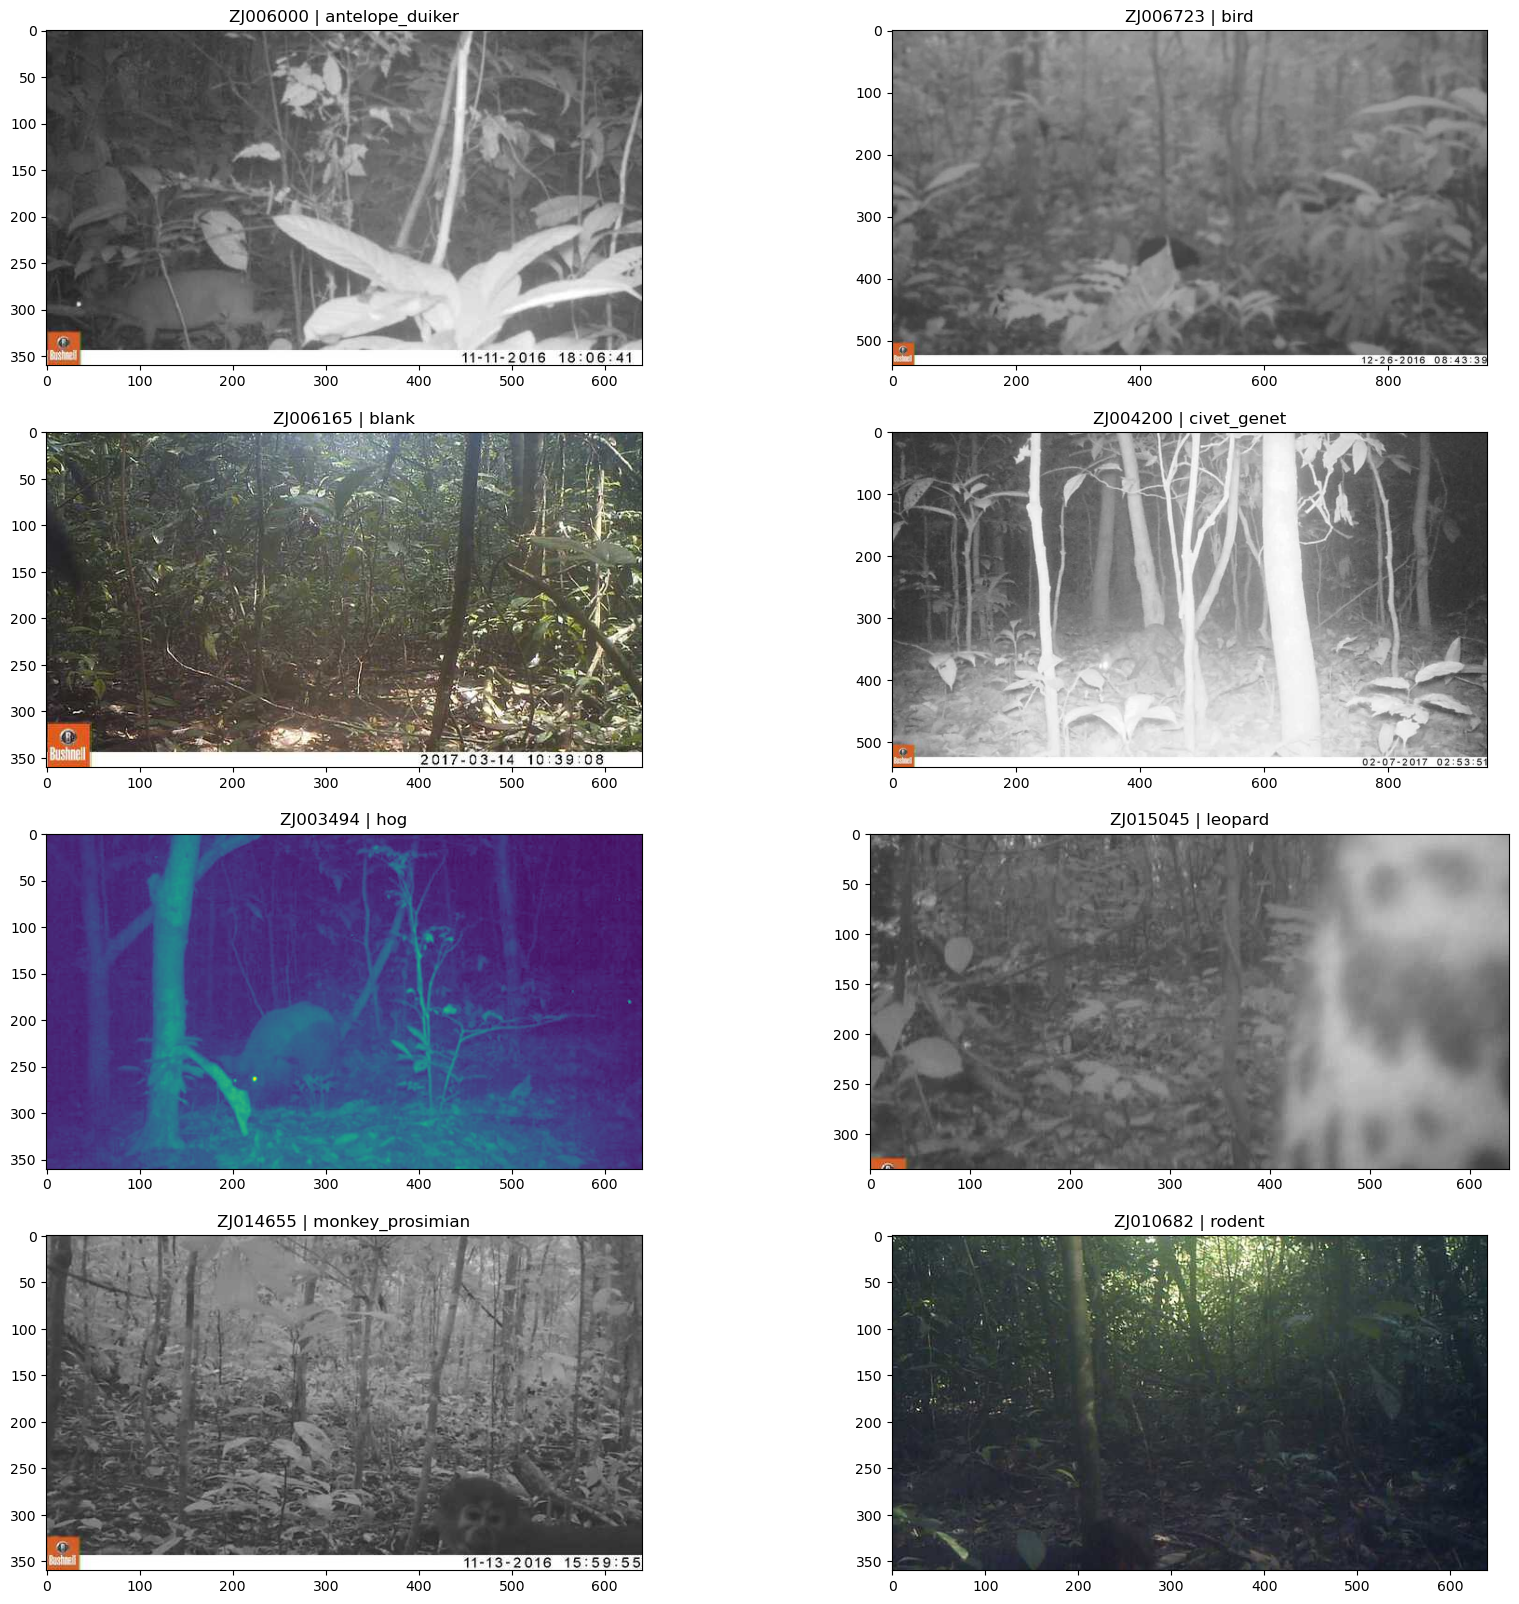

In [7]:
import matplotlib.image as mpimg

random_state = 42

# create a grid with 8 positions, one for each label (7 species, plus blanks)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # get an image ID for this species
    img_id = (
        train_labels[train_labels.loc[:,species] == 1]
        .sample(1, random_state=random_state)
        .index[0]
    )
    # load image as numpy array
    img = mpimg.imread(train_features.loc[img_id].filepath)
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

Let's look at the distribution of species across the training set, first in terms of overall counts and then in percentage terms.

In [8]:
train_labels.sum().sort_values(ascending=False)

monkey_prosimian    2492.0
antelope_duiker     2474.0
civet_genet         2423.0
leopard             2254.0
blank               2213.0
rodent              2013.0
bird                1641.0
hog                  978.0
dtype: float64

In [9]:
train_labels.sum().divide(train_labels.shape[0]).sort_values(ascending=False)

monkey_prosimian    0.151140
antelope_duiker     0.150049
civet_genet         0.146955
leopard             0.136705
blank               0.134219
rodent              0.122089
bird                0.099527
hog                 0.059316
dtype: float64

The competition dataset has been curated a little bit to produce a more uniform distribution than we would see in the actual data.


We can also look into the distribution of camera sites or image dimensions too.

In [10]:
train_features.groupby('site')['site'].agg('count').divide(train_features.shape[0]).sort_values(ascending=False)

site
S0060    0.068656
S0009    0.040272
S0063    0.033782
S0008    0.032812
S0036    0.027656
           ...   
S0092    0.000182
S0078    0.000121
S0079    0.000121
S0178    0.000121
S0102    0.000061
Name: site, Length: 148, dtype: float64

## 3. Split into train and dev sets
Now we split the training images into a training and a dev set. To ensure the model generalises well to unseen camera trap environments, each site is either wholly included in the training or dev set but not both. The dev set has also been constructed to have approximately the same distribution of animal classes as the training set.

In [11]:
x_train, y_train, x_dev, y_dev = split_train_test(train_features, train_labels)

Loading existing train, dev sets...
Checking loaded test set to match conditions...
Test size falls within acceptable range:
p = 0.2
dev_p = 0.19784085395439108
Test proportion falls within acceptable proportion:
Dataset proportion = antelope_duiker     0.150049
bird                0.099527
blank               0.134219
civet_genet         0.146955
hog                 0.059316
leopard             0.136705
monkey_prosimian    0.151140
rodent              0.122089
dtype: float64
Dev proportion = antelope_duiker     0.135193
bird                0.097793
blank               0.137339
civet_genet         0.140711
hog                 0.053035
leopard             0.136113
monkey_prosimian    0.175046
rodent              0.124770
dtype: float64
Returning loaded train and dev sets


Here's what `x_train` and `y_train` look like now:

In [12]:
x_train.head()

,filepath,site
id,,
ZJ000085,data/train_features/ZJ000085.jpg,S0051
ZJ000300,data/train_features/ZJ000300.jpg,S0051
ZJ000320,data/train_features/ZJ000320.jpg,S0051
ZJ000345,data/train_features/ZJ000345.jpg,S0051
ZJ000349,data/train_features/ZJ000349.jpg,S0051


In [13]:
y_train.head()

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
id,,,,,,,,
ZJ000085,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZJ000300,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
ZJ000320,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000345,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ZJ000349,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
x_train.shape, y_train.shape, x_dev.shape, y_dev.shape

((13226, 2), (13226, 8), (3262, 2), (3262, 8))

We can see that the split has resulted in roughly similar relative distributions of species across the train and eval sets.

In [15]:
split_pcts = pd.DataFrame(
    {
        "train": y_train.idxmax(axis=1).value_counts(normalize=True),
        "eval": y_dev.idxmax(axis=1).value_counts(normalize=True),
    }
)
print("Species percentages by split")
(split_pcts.fillna(0) * 100).astype(int)

Species percentages by split


,train,eval
antelope_duiker,15,13
bird,9,9
blank,13,13
civet_genet,14,14
hog,6,5
leopard,13,13
monkey_prosimian,14,17
rodent,12,12


## 4. Build the Dataset

We construct a [`ImageDataset`](model_funcs.py#ImageDataset) class in `tensorflow` and then load this dataset into a dataloader to let us iterate through the dataset in batches.

The dataset class handles how we access and preprocess the data so we can get from a filepath pointing to a `.jpg` image to an array of pixels that our tensorflow model can interpret. The class inherits from the `tf.keras.utils.Sequence` class which has similar functionality to the PyTorch `Dataset` class used in the benchmark. For advanced functionalities we could refactor `ImageDataset` to inherit from `tf.data.Dataset` but for now the current set up should be sufficient.

In [16]:
import tensorflow as tf

train_dataset = ImageDataset(x_train, y_train)
train_dataloader = tf.data.Dataset.from_generator(
    generator=train_dataset.__iter__,
    output_signature=train_dataset.element_spec
).batch(params.default.model.batch_size)
train_dataloader

<_BatchDataset element_spec={'image_id': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}>

## 5. Training the model

We'll use a pretrained ResNet50 model as our backbone. ResNets are one of the more popular networks for image classification tasks. The pretrained model outputs a 2048-dimension embedding, which we will then connect to two more dense layers, with a ReLU and Dropout step in between. 

These final layers, defined in `model.fc`, are the new "head" of our model, and allow us to transform the image embeddings produced by the pretrained "backbone" into the 8-dimensional output required to learn the species classification task we're tackling here. Prior to redefining it below, `model.fc` would be the final, dense layer connecting the 2048-dimension embedding to a 1000-dimension output (corresponding to the 1000 ImageNet classes that the pretrained model was trained on). We will instead prepare the model for the current task by redefining `model.fc` to produce an 8-dimensional output corresponding to our 8 species classes (including blanks). 

We'll also add a couple more layers in between. The `ReLU` layer introduces non-linearity into the model head, in effect activating important features and suppressing noise. And the `Dropout` layer is a commonly used regularization component that randomly drops some nodes from the previous layer's outputs (10% of nodes in this case) during each training step, mitigating our risk of overfitting.

In [18]:
from torch import nn
import torchvision.models as models


model = models.resnet50(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
    nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
    nn.Dropout(0.1),  # common technique to mitigate overfitting
    nn.Linear(
        100, 8
    ),  # final dense layer outputs 8-dim corresponding to our target classes
)

/Users/Felix_Gallagher/miniforge3/envs/wildlife-scanner/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/Felix_Gallagher/miniforge3/envs/wildlife-scanner/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/Felix_Gallagher/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:29<00:00, 3.53MB/s]


### Define our loss function
Cross entropy loss (or log loss) is a commonly used loss function for multi-class (not multi-label) image classification. We'll use this to compute loss for each training batch and then update our parameters accordingly. 

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Train the model
We're now ready to train our model!

We'll start simple and just run it for one epoch, but feel free to run it for more `num_epochs` if you've got the time. We hope to see a decreasing loss as training progresses, which will provide some evidence that the model is learning. Note that we haven't frozen any weights in the pretrained model, a choice which you may want to revisit and we discuss in a little more detail below.

For each epoch we'll iterate through the batches, and for each batch we'll do the following:
1. Zero out the gradients. PyTorch will sum the gradients from past batches when doing its backward pass, so in order to make sure we are only using the gradients computed for the current batch, we zero out the gradients at the beginning of each batch.
2. Run the forward pass.
3. Compute the loss and track it.
4. Compute our gradients and update our weight parameters.

In [20]:
num_epochs = 1

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the foward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

Starting epoch 1


 84%|████████▍ | 163/194 [56:30<22:56, 44.41s/it]

Now let's plot the loss by epoch and batch. The x-axis here is a tuple of `(epoch, batch)`.

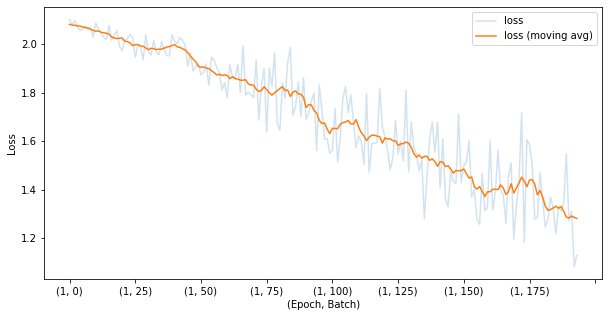

In [ ]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)

Good news, the loss is going down! This is an encouraging start, especially since we haven't done anything fancy yet.

### Save the model
We have the model loaded in memory already, so we don't really need to save the model, but it's often useful to do this so we can use it again later. 

Here's how:

In [ ]:
torch.save(model, "outputs/models/model.pth")

## 7. Evaluation
So far, not so bad. We've shown an improvement in the loss on the training set, but that tells us little about how our model will do on new data. Let's reload our saved model and try generating some predictions on the evaluation split we created earlier.

In [ ]:
loaded_model = torch.load("outputs/models/model.pth")

We create the eval dataset and dataloader just like we did earlier with the training dataset and dataloader:

In [ ]:
eval_dataset = ImagesDataset(x_dev, y_dev)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

### Make predictions
We'll iterate through the eval dataloader in batches, just like we did for training, but this time we aren't going to need to compute gradients or update weights. For each batch, we'll do the following:
1. Run the forward pass to get the model output or logits
2. Apply a softmax function to convert the logits into probability space with range[0,1]. During training, the softmax operation was handled internally by `nn.CrossEntropyLoss`. We aren't computing the loss now because we are just doing evaluation, but we still want the predictions to be in the range[0,1]. 
3. Store the results in a dataframe for further analysis

In [ ]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 65/65 [03:59<00:00,  3.68s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ005376,0.171700,0.192484,0.176443,0.009301,0.030189,0.065699,0.318819,0.035365
ZJ011044,0.001978,0.002307,0.001948,0.000101,0.001681,0.990360,0.000906,0.000719
ZJ005242,0.210068,0.189871,0.121386,0.012617,0.021859,0.031385,0.358011,0.054803
ZJ004518,0.238102,0.253908,0.109069,0.008890,0.023841,0.037896,0.283491,0.044803
ZJ000101,0.283641,0.121174,0.159294,0.024840,0.041801,0.041539,0.260422,0.067289
...,...,...,...,...,...,...,...,...
ZJ011868,0.130162,0.207689,0.163008,0.021061,0.053528,0.120070,0.230920,0.073561
ZJ002183,0.247485,0.180399,0.125990,0.009920,0.018781,0.022285,0.352043,0.043098
ZJ014186,0.069278,0.339674,0.087901,0.004488,0.021389,0.341253,0.110601,0.025416
ZJ011633,0.223148,0.143238,0.156081,0.032510,0.046612,0.049409,0.277509,0.071493


### Predicted labels distribution
First let's review the species distribution we saw in the training set.

In [ ]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()

True labels (training):


monkey_prosimian    973
antelope_duiker     925
civet_genet         896
blank               860
leopard             841
rodent              732
bird                608
hog                 348
dtype: int64

Here's the distribution of our predictions on the eval set. 

In [ ]:
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()

Predicted labels (eval):


monkey_prosimian    919
civet_genet         403
leopard             329
rodent              132
blank               122
antelope_duiker     106
bird                 48
hog                   2
dtype: int64

The actual evaluation set is more evenly distributed than our predictions, so we already know there is some room for improvement here.

In [ ]:
print("True labels (eval):")
y_dev.idxmax(axis=1).value_counts()

True labels (eval):


monkey_prosimian    325
antelope_duiker     308
civet_genet         298
blank               287
leopard             280
rodent              244
bird                203
hog                 116
dtype: int64

### Accuracy
Now let's compute how accurate our model is and compare that against some trivial baseline models. First let's get the labels with the highest score for each image.

In [ ]:
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()

ZJ005376    monkey_prosimian
ZJ011044             leopard
ZJ005242    monkey_prosimian
ZJ004518    monkey_prosimian
ZJ000101     antelope_duiker
dtype: object

Random guessing across 8 classes would yield an accuracy of 12.5% (1/8). But we could construct a slightly better trivial model by always guessing the most common class ("monkey_prosimian" images in this case).

If we were to always guess that an image is `monkey_prosimian`, we could achieve accuracy of 15.8%.

In [ ]:
eval_true = y_dev.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

0.1576904415332363

Let's see how our model compares. We take the species with the highest score for each image (`eval_predictions`) and compare that to the true labels.

In [ ]:
correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

0.49199417758369723

Our accuracy on the evaluation set is about 50%, which is not a bad start for a very simple first pass and one epoch of training.

Let's look at the predictions from another angle. 

We can see from the confusion matrix below that our model does reasonably well on some species, but we have plenty of room for improvement on antelopes, birds, hogs and blanks.

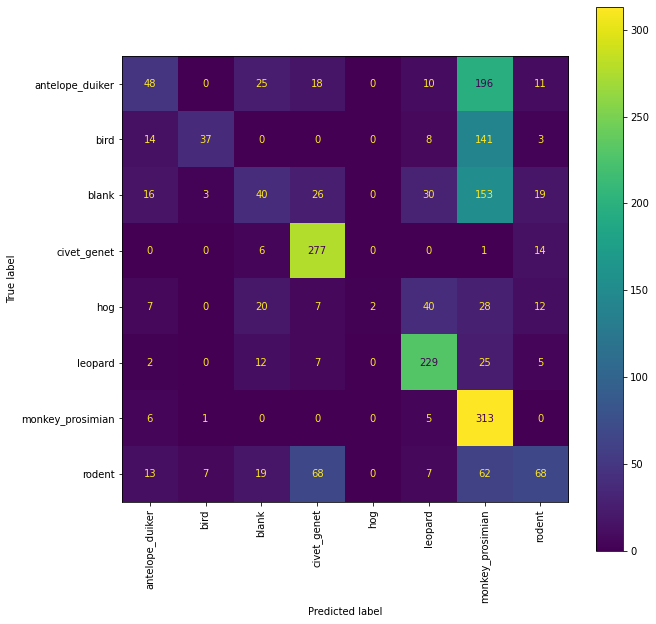

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 10))
cm = ConfusionMatrixDisplay.from_predictions(
    y_dev.idxmax(axis=1),
    eval_preds_df.idxmax(axis=1),
    ax=ax,
    xticks_rotation=90,
    colorbar=True,
)

That's where you come in! What can you do to improve on this benchmark?

Here are some ideas you might want to try:
* Train on the full training dataset. We've only used 50% of the training data so far.
* Train for more epochs. We've only done 1 so far.
* Try another pretrained model. For example, you may have more success with EfficientNet, or another ResNet model with more layers like ResNet152. See what's available from pytorch [here](https://pytorch.org/vision/stable/models.html). You may also want to review which models are or have been state of the art for image classification tasks, for example on [paperswithcode.com](https://paperswithcode.com/task/image-classification). Keep in mind that different models will require different input and output dimensions, so you'll need to update how you construct `model` above.
* Experiment with different loss functions.
* Experiment with different learning rates or learning rate schedulers.
* Add more layers to the model head (`model.fc`).
* You also may want to consider freezing the weights in the backbone model and only training the head (`model.fc`). If this results in higher accuracy, that suggests the current approach may be overwriting the backbone weights in a problematic way. One approach here would be to train just the model head, and then unfreeze the backbone but train at a lower learning rate.
* Training will be much faster using GPUs, but you will need to make some small tweaks to the code.
* As you become more comfortable iterating through different versions of the model, you may want to try out [PyTorch Lightning](https://www.pytorchlightning.ai/) or [Lightning Flash](https://lightning-flash.readthedocs.io/en/latest/quickstart.html), which build upon PyTorch and eliminate a lot of boilerplate code, in addition to providing a more complete research framework for deep learning problems.

## 8. Create submission

Last but not least, we'll want to participate in the competition and see where we stand on the leaderboard.

To do this we need to create predictions for the **competition test set** (not the eval set we used above). You don't have labels for these.

We'll create predictions in the same way we did for the `eval` set, but this time using the `test_features` we downloaded from the [competition website](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/data/).

In [ ]:
test_dataset = ImagesDataset(test_features.filepath.to_frame())
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [ ]:
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(test_dataloader, total=len(test_dataloader)):
        # run the forward step
        logits = model.forward(batch["image"])
        # apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

submission_df = pd.concat(preds_collector)
submission_df

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 140/140 [09:19<00:00,  4.00s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ016488,0.040287,0.016456,0.069033,0.639093,0.018142,0.018959,0.015982,0.182047
ZJ016489,0.257348,0.117252,0.138006,0.024684,0.049720,0.057412,0.294213,0.061365
ZJ016490,0.242068,0.075779,0.177219,0.098522,0.061314,0.060584,0.160722,0.123793
ZJ016491,0.009359,0.010228,0.009832,0.000861,0.008720,0.952021,0.005001,0.003978
ZJ016492,0.242449,0.117502,0.119074,0.007304,0.017310,0.022663,0.443947,0.029752
...,...,...,...,...,...,...,...,...
ZJ020947,0.176772,0.180421,0.153451,0.008706,0.040353,0.151517,0.258835,0.029944
ZJ020948,0.270863,0.149436,0.135711,0.009466,0.028289,0.054232,0.311244,0.040758
ZJ020949,0.072901,0.022102,0.097448,0.489528,0.043097,0.028081,0.024680,0.222163
ZJ020950,0.167972,0.235275,0.123283,0.008515,0.028146,0.047482,0.340371,0.048957


Let's check a couple things on `submission_df` before submitting to the platform. We'll want to make sure our submission's index and column labels match the submission format. (The DrivenData platform will do these data integrity checks as well, but it will be quicker to detect problems this way.)

In [ ]:
submission_format = pd.read_csv("data/submission_format.csv", index_col="id")

assert all(submission_df.index == submission_format.index)
assert all(submission_df.columns == submission_format.columns)

Looks like we're ready to submit! Save the dataframe out to a CSV file and then upload it via the [Submissions page](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/submissions/) on the competition website.

In [ ]:
submission_df.to_csv("outputs/submission_df.csv")

How did we do? We should get a score of ~1.8, though your results may differ slightly due to non-determinism in model training. (For reference, a randomly generated submission yields a score of something like ~2.4.)

![benchmark submission](https://drivendata-public-assets.s3.amazonaws.com/conservision-benchmark-score.jpg)

Now it is up to you to improve on this benchmark!

Head over to the [competition](https://www.drivendata.org/competitions/87/competition-image-classification-wildlife-conservation/) for data and more background info, or the [competition forum](https://community.drivendata.org/c/conser-vision/87) if you have any questions. Good luck!